In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timedelta, time
import csv
from typing import Any, Dict, List, Optional
from openpyxl import load_workbook
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(
    'ignore',
    message=r'`sklearn\.utils\.parallel\.delayed` should be used with `sklearn\.utils\.parallel\.Parallel`',
    category=UserWarning,
)



In [2]:
from pathlib import Path
from typing import Optional

def find_repo_root(start: Optional[Path] = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / 'data').exists():
            return parent
    return p

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
# OUTPUTS removed; use PROCESSED or PLOTS
print('ROOT:', ROOT)
print('RAW:', RAW)

def resolve_input(filename: str) -> Path:
    # prefer data/raw; fall back to repo root for backward compatibility
    p1 = RAW / filename
    p2 = PROCESSED / filename
    p3 = ROOT / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    if p3.exists():
        return p3
    raise FileNotFoundError(f'Cannot find {filename} in {RAW} or {ROOT}')


ROOT: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data
RAW: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\raw


In [3]:
# Load prebuilt master data
master_path = resolve_input("master.csv")
df = pd.read_csv(master_path, parse_dates=["timestamp"])
df = df.sort_values("timestamp").set_index("timestamp")
print("Loaded", master_path, "with", len(df), "rows")

Loaded C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master.csv with 16682 rows


In [4]:
# Normalize fertilization flags into binary + type A/B columns
if 'fertilization_flag' in df.columns:
    fert_raw = df['fertilization_flag'].fillna(0)
    df['fertilization_flag'] = (fert_raw > 0).astype(int)
    df['fertilization_type_a_flag'] = (fert_raw == 1).astype(int)
    df['fertilization_type_b_flag'] = (fert_raw == 2).astype(int)
    unexpected = set(fert_raw.dropna().unique()) - {0, 1, 2}
    if unexpected:
        print('Unexpected fertilization_flag values:', sorted(unexpected))


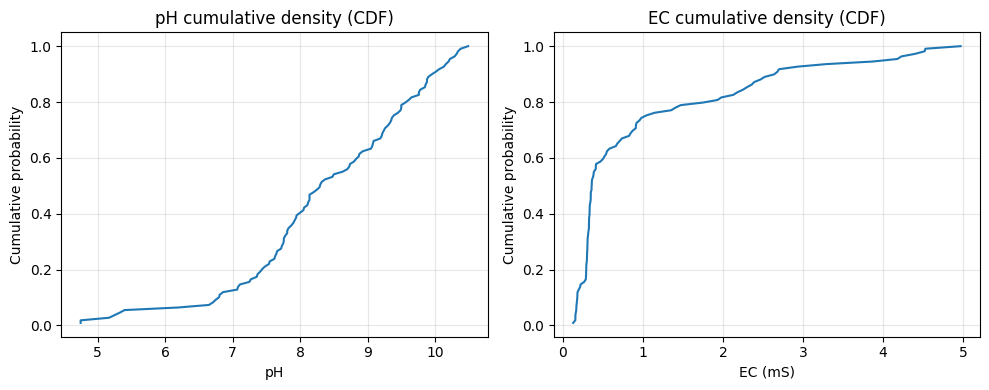

pH 90th percentile: 9.962
EC 90th percentile: 2.648


In [5]:
# Cumulative density (CDF) for pH/EC
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if 'ph' in df.columns:
    ph_vals = df.loc[df['ph'].notna(), 'ph'].values
    if len(ph_vals) > 0:
        ph_sorted = np.sort(ph_vals)
        ph_cdf = np.arange(1, len(ph_sorted) + 1) / len(ph_sorted)
        ax[0].plot(ph_sorted, ph_cdf)
        ax[0].set_title('pH cumulative density (CDF)')
        ax[0].set_ylabel('Cumulative probability')
        ax[0].set_xlabel('pH')
    else:
        ax[0].set_title('pH cumulative density (CDF) (no data)')
else:
    ax[0].set_title('pH cumulative density (CDF) (missing)')
if 'ec_ms' in df.columns:
    ec_vals = df.loc[df['ec_ms'].notna(), 'ec_ms'].values
    if len(ec_vals) > 0:
        ec_sorted = np.sort(ec_vals)
        ec_cdf = np.arange(1, len(ec_sorted) + 1) / len(ec_sorted)
        ax[1].plot(ec_sorted, ec_cdf)
        ax[1].set_title('EC cumulative density (CDF)')
        ax[1].set_ylabel('Cumulative probability')
        ax[1].set_xlabel('EC (mS)')
    else:
        ax[1].set_title('EC cumulative density (CDF) (no data)')
else:
    ax[1].set_title('EC cumulative density (CDF) (missing)')
for a in ax: a.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

p90_ph = np.percentile(ph_vals, 90) if 'ph' in df.columns and len(ph_vals) else None
p90_ec = np.percentile(ec_vals, 90) if 'ec_ms' in df.columns and len(ec_vals) else None
print('pH 90th percentile:', p90_ph)
print('EC 90th percentile:', p90_ec)

if p90_ph is not None:
    ax[0].axvline(p90_ph, color='red', linestyle='--')
    ax[0].annotate(f'P90={p90_ph:.2f}', (p90_ph, 0.9), xytext=(5, -10),
                   textcoords='offset points', color='red')
if p90_ec is not None:
    ax[1].axvline(p90_ec, color='red', linestyle='--')
    ax[1].annotate(f'P90={p90_ec:.2f}', (p90_ec, 0.9), xytext=(5, -10),
                   textcoords='offset points', color='red')


In [6]:
# EC enrichment by distance to Fert B events
from datetime import timedelta

if 'fertilization_type_b_flag' in df.columns:
    fert_b_times = df.index[df['fertilization_type_b_flag'].fillna(0) == 1]
    ec_samples = df.loc[df['ec_ms'].notna(), ['ec_ms']].copy()

    # compute min delta hours to nearest Fert B event for each EC sample
    if len(fert_b_times) > 0:
        fert_b_array = fert_b_times.values
        deltas = []
        for t in ec_samples.index:
            idx = np.argmin(np.abs(fert_b_array - np.array(t, dtype='datetime64[ns]')))
            closest_time = fert_b_times[idx]
            delta_hours = abs((t - closest_time).total_seconds()) / 3600.0
            deltas.append(delta_hours)
        ec_samples['delta_hours_to_fert_b'] = deltas

        bins = [0, 4, 12, 24, 1e9]
        labels = ['0-4h', '4-12h', '12-24h', '>24h']
        ec_samples['bin'] = pd.cut(ec_samples['delta_hours_to_fert_b'], bins=bins, labels=labels, right=True)

        summary = (ec_samples
                   .groupby('bin')['ec_ms']
                   .agg(['count', 'mean', 'median', lambda s: (s > 1).mean() * 100, lambda s: (s > 2).mean() * 100])
                   .rename(columns={'<lambda_0>': 'pct_ec_gt_1', '<lambda_1>': 'pct_ec_gt_2'}))
        display(summary)
    else:
        print('No Fert B events found.')
else:
    print('fertilization_type_b_flag not found in df.')


No Fert B events found.


In [7]:
# EC tail breakdown and timestamps for high values
ec_vals = df['ec_ms'].dropna()
for thr in [1, 2, 3, 4]:
    pct = (ec_vals > thr).mean() * 100
    print(f'EC > {thr}: {pct:.2f}% ({(ec_vals > thr).sum()}/{len(ec_vals)})')

high_ec = df.loc[df['ec_ms'] > 2, ['ec_ms']].sort_values('ec_ms', ascending=False)
display(high_ec)


EC > 1: 25.69% (28/109)
EC > 2: 18.35% (20/109)
EC > 3: 7.34% (8/109)
EC > 4: 5.50% (6/109)


,ec_ms
timestamp,
2025-09-21 08:40:00,4.97
2025-09-21 13:40:00,4.53
2025-09-21 10:30:00,4.52
2025-09-21 11:40:00,4.40
2025-09-21 07:20:00,4.23
2025-08-10 15:20:00,4.18
2025-09-21 15:30:00,3.87
2025-08-11 08:10:00,3.29
2025-08-18 14:40:00,2.93


In [8]:
# pH tail breakdown and timestamps for low/high values
ph_vals = df['ph'].dropna()
low_thresholds = [5.5, 6.0]
high_thresholds = [8.5, 9.0]

for thr in low_thresholds:
    pct = (ph_vals < thr).mean() * 100
    print(f'pH < {thr}: {pct:.2f}% ({(ph_vals < thr).sum()}/{len(ph_vals)})')
for thr in high_thresholds:
    pct = (ph_vals > thr).mean() * 100
    print(f'pH > {thr}: {pct:.2f}% ({(ph_vals > thr).sum()}/{len(ph_vals)})')

low_ph = df.loc[df['ph'] < low_thresholds[0], ['ph']].sort_values('ph')
high_ph = df.loc[df['ph'] > high_thresholds[-1], ['ph']].sort_values('ph', ascending=False)
print('Lowest pH samples:')
display(low_ph)
print('Highest pH samples:')
display(high_ph)


pH < 5.5: 5.50% (6/109)
pH < 6.0: 5.50% (6/109)
pH > 8.5: 45.87% (50/109)
pH > 9.0: 37.61% (41/109)
Lowest pH samples:


,ph
timestamp,
2025-09-21 07:20:00,4.75
2025-09-21 08:40:00,4.75
2025-09-21 10:30:00,5.17
2025-09-21 11:40:00,5.25
2025-09-21 13:40:00,5.33
2025-09-21 15:30:00,5.40


Highest pH samples:


,ph
timestamp,
2025-08-31 12:30:00,10.49
2025-09-01 12:30:00,10.38
2025-09-02 15:00:00,10.34
2025-09-03 15:20:00,10.32
2025-08-28 15:00:00,10.29
2025-09-10 15:50:00,10.22
2025-09-15 15:30:00,10.20
2025-09-10 13:50:00,10.16
2025-09-15 14:10:00,10.13


In [9]:
# Link pH extremes to closest fert event
low_ph = df.loc[df['ph'] < 5.5, ['ph']].copy()
high_ph = df.loc[df['ph'] > 9.0, ['ph']].copy()

fert_any = df['fertilization_flag'].fillna(0) > 0
fert_a = df['fertilization_type_a_flag'].fillna(0) == 1
fert_b = df['fertilization_type_b_flag'].fillna(0) == 1

fert_times = []
fert_types = []
for t in df.index[fert_any]:
    if fert_a.loc[t]:
        fert_times.append(t); fert_types.append('A')
    elif fert_b.loc[t]:
        fert_times.append(t); fert_types.append('B')
    else:
        fert_times.append(t); fert_types.append('unknown')

fert_df = pd.DataFrame({'fert_time': fert_times, 'fert_type': fert_types}).sort_values('fert_time')

def attach_closest_fert(ph_df):
    out = ph_df.copy()
    out['closest_fert_time'] = pd.NaT
    out['closest_fert_type'] = None
    out['delta_hours'] = None
    if fert_df.empty:
        return out
    fert_times_series = fert_df['fert_time'].values
    for t in out.index:
        idx = np.argmin(np.abs(fert_times_series - np.array(t, dtype='datetime64[ns]')))
        closest_time = fert_df.iloc[idx]['fert_time']
        closest_type = fert_df.iloc[idx]['fert_type']
        delta_hours = abs((t - closest_time).total_seconds()) / 3600.0
        out.at[t, 'closest_fert_time'] = closest_time
        out.at[t, 'closest_fert_type'] = closest_type
        out.at[t, 'delta_hours'] = delta_hours
    return out

display(attach_closest_fert(low_ph))
display(attach_closest_fert(high_ph))


,ph,closest_fert_time,closest_fert_type,delta_hours
timestamp,,,,
2025-09-21 07:20:00,4.75,2025-09-21 08:30:00,A,1.166667
2025-09-21 08:40:00,4.75,2025-09-21 08:30:00,A,0.166667
2025-09-21 10:30:00,5.17,2025-09-21 08:30:00,A,2.0
2025-09-21 11:40:00,5.25,2025-09-21 08:30:00,A,3.166667
2025-09-21 13:40:00,5.33,2025-09-21 08:30:00,A,5.166667
2025-09-21 15:30:00,5.40,2025-09-21 08:30:00,A,7.0


,ph,closest_fert_time,closest_fert_type,delta_hours
timestamp,,,,
2025-07-24 11:00:00,9.49,2025-07-24 15:10:00,A,4.166667
2025-07-24 15:10:00,9.22,2025-07-24 15:10:00,A,0.0
2025-08-17 12:40:00,9.30,2025-08-17 08:30:00,A,4.166667
2025-08-18 14:40:00,9.19,2025-08-18 08:30:00,A,6.166667
2025-08-19 12:30:00,9.61,2025-08-19 08:30:00,A,4.0
2025-08-19 17:30:00,9.08,2025-08-19 08:30:00,A,9.0
2025-08-20 12:00:00,9.21,2025-08-20 12:00:00,A,0.0
2025-08-25 09:00:00,9.07,2025-08-25 12:00:00,A,3.0
2025-08-25 16:00:00,9.86,2025-08-25 12:00:00,A,4.0


In [10]:
# Compare conditions for high pH vs normal pH (Fert B, 0-8h window)
if 'fertilization_type_b_flag' in df.columns:
    fert_b_times = df.index[df['fertilization_type_b_flag'].fillna(0) == 1]
    rows = []
    for t in fert_b_times:
        window = (df.index >= t) & (df.index <= t + pd.Timedelta(hours=8))
        sub = df.loc[window]
        rows.append({
            'fert_time': t,
            'ph_min_0_8h': sub['ph'].min(),
            'ph_max_0_8h': sub['ph'].max(),
            'irrig_total_0_8h': sub['irrigation_ml_current'].fillna(0).sum() if 'irrigation_ml_current' in sub.columns else None,
            'temp_mean_0_8h': sub['internal_air_temp_c'].mean() if 'internal_air_temp_c' in sub.columns else None,
            'rh_mean_0_8h': sub['internal_rh_%'].mean() if 'internal_rh_%' in sub.columns else None,
            'ET0_mean_0_8h': sub['ET0'].mean() if 'ET0' in sub.columns else None,
        })

    ph_cond_df = pd.DataFrame(rows).dropna(subset=['ph_max_0_8h'])
    high = ph_cond_df[ph_cond_df['ph_max_0_8h'] >= 9.0]
    normal = ph_cond_df[ph_cond_df['ph_max_0_8h'] < 9.0]

    print('High pH windows:', len(high), 'Normal pH windows:', len(normal))
    print('High pH mean irrigation:', high['irrig_total_0_8h'].mean())
    print('Normal pH mean irrigation:', normal['irrig_total_0_8h'].mean())
    print('High pH mean temp:', high['temp_mean_0_8h'].mean(),
          'RH:', high['rh_mean_0_8h'].mean(),
          'ET0:', high['ET0_mean_0_8h'].mean())
    print('Normal pH mean temp:', normal['temp_mean_0_8h'].mean(),
          'RH:', normal['rh_mean_0_8h'].mean(),
          'ET0:', normal['ET0_mean_0_8h'].mean())

    display(ph_cond_df.sort_values('ph_max_0_8h', ascending=False))
else:
    print('fertilization_type_b_flag not found in df.')


KeyError: ['ph_max_0_8h']

In [ ]:
# Compare pH extremes vs Fert B dose
dose_cols = [
    'Ammonium Nitrate [mg] -NH4NO3',
    'Monopotassium Phosphate[mg] -KH2PO4',
    'Potassium Chloride[mg] - KCL',
    'Phosphoric acid[mg]-H3PO4',
    'Kortin [mg]',
    'Gypsum - CaSO4*2H2O [mg]',
]
dose_cols = [c for c in dose_cols if c in df.columns]
if 'fertilization_type_b_flag' in df.columns and dose_cols:
    fert_b_times = df.index[df['fertilization_type_b_flag'].fillna(0) == 1]
    rows = []
    for t in fert_b_times:
        window = (df.index >= t) & (df.index <= t + pd.Timedelta(hours=8))
        sub = df.loc[window]
        dose_total = df.loc[t, dose_cols].fillna(0).sum()
        rows.append({
            'fert_time': t,
            'dose_total': dose_total,
            'ph_min_0_8h': sub['ph'].min(),
            'ph_max_0_8h': sub['ph'].max(),
        })
    ph_dose_df = pd.DataFrame(rows).dropna(subset=['ph_max_0_8h'])
    display(ph_dose_df.sort_values('ph_max_0_8h', ascending=False))
    if len(ph_dose_df) > 1:
        print('Correlation (dose_total vs ph_max_0_8h):', ph_dose_df['dose_total'].corr(ph_dose_df['ph_max_0_8h']))
else:
    print('fertilization_type_b_flag not found or dose columns missing.')


,fert_time,dose_total,ph_min_0_8h,ph_max_0_8h
32,2025-08-31 08:30:00,325.566437,10.49,10.49
33,2025-09-01 08:30:00,325.566437,9.76,10.38
34,2025-09-02 08:30:00,325.566437,8.00,10.34
35,2025-09-03 08:30:00,325.566437,8.87,10.32
31,2025-08-28 08:30:00,325.566437,7.62,10.29
40,2025-09-10 08:30:00,325.566437,9.50,10.22
43,2025-09-15 08:30:00,325.566437,9.45,10.20
41,2025-09-11 08:30:00,325.566437,9.24,10.06
37,2025-09-07 08:30:00,325.566437,8.25,10.01
42,2025-09-14 08:30:00,325.566437,8.48,9.95


Correlation (dose_total vs ph_max_0_8h): -0.45699632640088


,fert_time,dose_total,max_ec_0_8h
49,2025-09-21 08:30:00,976.699311,4.97000
27,2025-08-21 13:00:00,651.132874,0.82782
28,2025-08-25 12:00:00,424.566437,0.32700
3,2025-07-20 12:50:00,325.566437,0.52000
7,2025-07-27 11:00:00,325.566437,0.37710
9,2025-07-29 15:20:00,325.566437,1.40600
5,2025-07-23 11:20:00,325.566437,0.36050
6,2025-07-24 15:10:00,325.566437,0.55030
1,2025-07-16 09:00:00,325.566437,0.38700
13,2025-08-04 09:00:00,325.566437,2.64000


Correlation (dose_total vs max_ec_0_8h): 0.4343260321827376


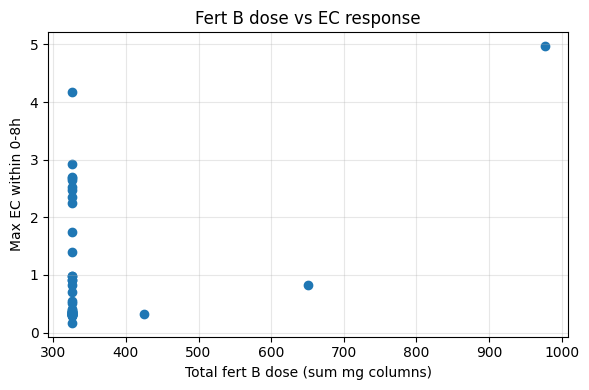

In [ ]:
# Correlate fert dose (Type B) with max EC within 0-8h after event
from datetime import timedelta

# Choose fert dose columns (Type B has these typically populated)
dose_cols = [
    'Ammonium Nitrate [mg] -NH4NO3',
    'Monopotassium Phosphate[mg] -KH2PO4',
    'Potassium Chloride[mg] - KCL',
    'Phosphoric acid[mg]-H3PO4',
    'Kortin [mg]',
    'Gypsum - CaSO4*2H2O [mg]',
]
dose_cols = [c for c in dose_cols if c in df.columns]

if not dose_cols:
    print('No fert dose columns found in df.')
elif 'fertilization_type_b_flag' not in df.columns:
    print('fertilization_type_b_flag not found in df.')
else:
    fert_b_times = df.index[df['fertilization_type_b_flag'].fillna(0) == 1]
    rows = []
    for t in fert_b_times:
        # total dose at event time (sum of available columns)
        dose_total = df.loc[t, dose_cols].fillna(0).sum()
        # max EC within 0-8h after event
        window = (df.index >= t) & (df.index <= t + timedelta(hours=8))
        max_ec = df.loc[window, 'ec_ms'].max()
        rows.append({'fert_time': t, 'dose_total': dose_total, 'max_ec_0_8h': max_ec})

    dose_df = pd.DataFrame(rows).dropna(subset=['max_ec_0_8h'])
    display(dose_df.sort_values('dose_total', ascending=False))

    # Simple correlation (linear)
    if len(dose_df) > 1:
        corr = dose_df['dose_total'].corr(dose_df['max_ec_0_8h'])
        print('Correlation (dose_total vs max_ec_0_8h):', corr)

    # Plot
    plt.figure(figsize=(6,4))
    plt.scatter(dose_df['dose_total'], dose_df['max_ec_0_8h'])
    plt.xlabel('Total fert B dose (sum mg columns)')
    plt.ylabel('Max EC within 0-8h')
    plt.title('Fert B dose vs EC response')
    plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()


In [ ]:
# Summarize conditions around each Fert B event (0-8h window)
from datetime import timedelta

if 'fertilization_type_b_flag' in df.columns:
    fert_b_times = df.index[df['fertilization_type_b_flag'].fillna(0) == 1]
    rows = []
    for t in fert_b_times:
        window = (df.index >= t) & (df.index <= t + timedelta(hours=8))
        sub = df.loc[window]
        rows.append({
            'fert_time': t,
            'ec_max_0_8h': sub['ec_ms'].max(),
            'irrig_total_0_8h': sub['irrigation_ml_current'].fillna(0).sum() if 'irrigation_ml_current' in sub.columns else None,
            'temp_mean_0_8h': sub['internal_air_temp_c'].mean() if 'internal_air_temp_c' in sub.columns else None,
            'rh_mean_0_8h': sub['internal_rh_%'].mean() if 'internal_rh_%' in sub.columns else None,
            'ET0_mean_0_8h': sub['ET0'].mean() if 'ET0' in sub.columns else None,
        })

    cond_df = pd.DataFrame(rows).sort_values('ec_max_0_8h', ascending=False)
    display(cond_df)
else:
    print('fertilization_type_b_flag not found in df.')


,fert_time,ec_max_0_8h,irrig_total_0_8h,temp_mean_0_8h,rh_mean_0_8h,ET0_mean_0_8h
49,2025-09-21 08:30:00,4.97000,566.666667,31.410484,62.007456,0.211294
17,2025-08-10 08:30:00,4.18000,500.000000,34.822000,52.422231,0.324503
22,2025-08-18 08:30:00,2.93000,1233.333333,32.243214,58.378647,0.379860
11,2025-07-31 09:00:00,2.70000,600.000000,32.854800,57.648656,0.399711
21,2025-08-17 08:30:00,2.68000,1000.000000,33.211786,53.559788,0.374687
13,2025-08-04 09:00:00,2.64000,600.000000,31.840546,64.147505,0.360267
20,2025-08-14 12:30:00,2.52000,733.333333,31.873469,69.636630,0.109954
14,2025-08-05 08:30:00,2.47000,500.000000,32.163387,62.241197,0.369035
16,2025-08-07 08:30:00,2.36000,600.000000,32.751754,59.960028,0.373126
15,2025-08-06 08:30:00,2.25000,500.000000,32.719883,61.998861,0.377966


In [ ]:
# Compare conditions for high vs low EC response windows
cond_df_clean = cond_df.dropna(subset=['ec_max_0_8h']).copy()
high = cond_df_clean[cond_df_clean['ec_max_0_8h'] >= 2.5]
low = cond_df_clean[cond_df_clean['ec_max_0_8h'] <= 0.5]

print('High EC events:', len(high), 'Low EC events:', len(low))
print('High EC mean irrigation:', high['irrig_total_0_8h'].mean())
print('Low EC mean irrigation:', low['irrig_total_0_8h'].mean())
print('High EC mean temp:', high['temp_mean_0_8h'].mean(),
      'RH:', high['rh_mean_0_8h'].mean(),
      'ET0:', high['ET0_mean_0_8h'].mean())
print('Low EC mean temp:', low['temp_mean_0_8h'].mean(),
      'RH:', low['rh_mean_0_8h'].mean(),
      'ET0:', low['ET0_mean_0_8h'].mean())


High EC events: 7 Low EC events: 20
High EC mean irrigation: 747.6190476142857
Low EC mean irrigation: 1493.3333333900002
High EC mean temp: 32.60804288046648 RH: 59.68584452332362 ET0: 0.30861101953061226
Low EC mean temp: 31.482348164285714 RH: 63.637673943928576 ET0: 0.27938553577755104
